Author: Germano Gabbianelli

License: GNU GPL v3

## Import the required dependencies

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

## Configure the Random number Generators

We set an initial seed to ensure reproducibility

In [ ]:
RANDOM_SEED = 666

We use a seed sequence to initialize all the possible random number generators.

In [ ]:
seed_seq = np.random.SeedSequence(RANDOM_SEED)

MAP_SEED, ENV_SEED, ALG_SEED = seed_seq.spawn(3)

Unfortunately, for some reason, gym checks that the seeds are `int`s,
so we need this small trick

In [ ]:
MAP_SEED = int(MAP_SEED.generate_state(1)[0])
ENV_SEED = int(ENV_SEED.generate_state(1)[0])

## Configure the FrozenLake Environment

We can generate a random map using `generate_random_map`

In [15]:
M = MAP_SIZE = 5
FROZEN_PROBABILITY=0.9

map = generate_random_map(
    size=MAP_SIZE,
    p=FROZEN_PROBABILITY,
    seed=ENV_SEED,
)
print(map)

['SFFFF', 'FFFFF', 'FFFFF', 'FHFFF', 'FFFHG']


Or we can specify one ourselves:

In [16]:
# rename this variable to `map` to use this map
# everything works (should) the same but you'll have
# a bit longer training times
_map = [
    "FFFFF",
    "FHFFF",
    "FHFHF",
    "FHHHF",
    "FFSHG"
]

Let us initialize the gym environment and print it

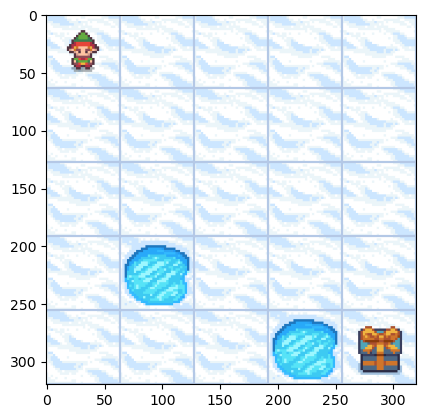

In [17]:
env = gym.make(
    "FrozenLake-v1",
    is_slippery=False,
    render_mode="rgb_array",
    desc=map,
)


env.reset(seed=ENV_SEED) # set the random seed

env_image = env.render()
plt.imshow(env_image)

## Define an Interface for our Algorithms

Let us define a base class for all our algorithms

In [18]:
import abc

class Algorithm(abc.ABC):

    def __init__(self, env, df=0.95, seed=None):
        self.env = env
        self.df = df
        
        # useful as a shortcut
        self.S = env.observation_space.n
        self.A = env.action_space.n

        # initialize the random number generator
        self.rng = np.random.default_rng(seed)


    def step(self, t):
        raise NotImplementedError

    @abc.abstractproperty
    def policy(self):
        raise NotImplementedError

We also define some utility functions/classes (hidden by default)

In [19]:
## Utility functions/classes

def plot_policy(policy):

    U = (policy[:, 2] - policy[:, 0]).reshape(M, M)
    V = (policy[:, 3] - policy[:, 1]).reshape(M, M)

    x = np.arange(M) + 0.5
    X, Y = np.meshgrid(x, x[::-1])

    #U = np.ones(25).reshape(5,5)
    #V = U

    fig, ax = plt.subplots()


    ax.imshow(env_image, extent=[0, M, 0, M])

    ax.quiver(X, Y, U,V, angles='xy', scale_units='xy', scale=2)
    ax.set(xlim=[0,M], ylim=[0,M], aspect="equal")

    plt.show()

    
def compute_P(env):
    S = env.observation_space.n
    A = env.action_space.n

    P = P = np.zeros((S, A, S))

    for (state, state_data) in env.P.items():
        for (action, next_data) in state_data.items():
            for (prob, next_state, reward, terminated) in next_data:
                P[state, action, next_state] = prob

    return P


def compute_R(env):
    S = env.observation_space.n
    A = env.action_space.n

    R = np.zeros((S, A, S))

    for (state, state_data) in env.P.items():
        for (action, next_data) in state_data.items():
            for (prob, next_state, reward, terminated) in next_data:
                R[state, action, next_state] = reward

    return R


class InvalidatePolicy:
    def __set_name__(self, owner, name):
        self.name = name

    def __set__(self, instance, value):
        instance.__dict__[self.name] = value
        instance.__dict__.pop("policy", None)

## Linear Programming Formulation Recap

The Reinforcement Learning Problem can be formulated with the following two linear programs:

$\newcommand{\One}[1]{1\!\!1\{#1\}}$
$$
    \begin{aligned}[c]
        & \max_{\mu\succeq 0}\; \langle \mu, r \rangle \\
        & \textrm{subject to}\ E^\intercal \mu =(1-\gamma)\nu_0 + \gamma P^\intercal \mu \\
    \end{aligned}\quad\;\;
    \begin{aligned}[c]
    &\min_{v}\; (1-\gamma) \langle \nu_0, v\rangle \\
    &\textrm{subject to}\ Ev \geq r+\gamma Pv,
    \end{aligned}
$$

From which we can derive the Lagrangian

$$
\begin{aligned}
\mathcal{L}(v, \mu) &= (1-\gamma)\langle\nu_0, v\rangle + \langle\mu, r+\gamma Pv - Ev\rangle \\
 &= \langle\mu, r \rangle + \langle v, (1-\gamma)\nu_0 + \gamma P^\intercal \mu - E^\intercal \mu \rangle .
\end{aligned}
$$

We then use the gradients of the Lagrangian as losses for two alternativing mirror descent / ascent instances.

<!--
Now consider the random variable $W=(X_0, X, A, R, X')$, where $X_0\sim \nu_0$,
$(X,A)\sim\mu$, $R=r(X,A)$, and $X'\sim p(\cdot\mid X,A)$. Then, we can define
the unbiased estimators

*   $\hat{\nu}_0(x) = \One{X^0=x}$,
*   $\hat{r}(x,a)= \One{X=x, A=a}R$
*   $\hat{p}(x'\mid x,a)=\One{X'=x'\mid X=x, A=a}$ -->

### Exercise: compute the gradients

Compute the gradients of the Lagrangian wrt $v$ and $\mu$.

## A base class for our Tabular algorithms

We are now going to write a base class for all our tabular algorithms.
It initializes the variables used in our algorithms (`v` and `mu`),
and their learning rate. It also defines a `mu_sum` variable, because
the output policy is extracted from the sum of the `mu`s (Do you remember
this deatil from yesterday's lesson?).

It also makes avaiable to subclasses the attributes `P`, `r` and `nu0`.

In [ ]:
from functools import cached_property


class TabularBase(Algorithm):

    # Makes sure the policy is deleted every time mu_sum is assigned
    mu_sum = InvalidatePolicy()

    def __init__(self, env, **kwds):
        lr_v = lr_mu = kwds.pop("lr", 0.01)
        self.lr_v = kwds.pop("lr_v", lr_v)
        self.lr_mu = kwds.pop("lr_mu", lr_mu)
        
        super().__init__(env, **kwds)

        # initialize variables
        self.v = np.zeros(self.S)
        self.mu = np.ones((self.S, self.A)) / (self.S * self.A)
        self.mu_sum = self.mu

    @cached_property
    # @cached_property computes the attribute on first access and then caches it
    def policy(self):
        ###################################
        # Exercise                        #
        ###################################
        # What output policy should we return?
        # Hint: extract it from self.mu_sum
        return ...

    @cached_property
    def P(self):
        return compute_P(self.env)

    @cached_property
    def r(self):
        R = compute_R(self.env)
        return (self.P * R).sum(2)

    @property
    def nu0(self):
        return self.env.initial_state_distrib


We define a small utility class to log the value of the policies produced by our
algorithm during training (hidden by default):

In [ ]:
class LoggingMixin:
    "Utility class which evaluates the current policy at each step\
     and saves the values in `_rewards`."
    
    def __init__(self, env, *args, log_every=10, **kwds):
        super().__init__(env, *args, **kwds)

        self._log_every = log_every
        self._I = np.eye(self.S)
        self._rewards = []

    def evaluate_policy(self, policy):
        P = (self.P * policy.reshape(self.S, self.A, 1)).sum(1)
        r = (self.r * policy).sum(1)

        v = np.linalg.inv(self._I - self.df * P) @ r
        return (1-self.df) * self.nu0 @ v

    def step(self, t):
        super().step(t)

        if t % self._log_every == 0:
            r = self.evaluate_policy(self.policy)
            self._rewards.append(r)

## Compute the exact solution with a solver

Before proceeding to implement some algorithm ourselves, it is insightful to use a Linear Programming solver (i.e. `scipy.optimize.linprog`) to find a solution
for our problem.

The solver requires the objective to be in the form $\langle x,c \rangle$, where $x$ is the variable to *minimize*,
and the constraints to be in the form $Ax = b$.

We can therefore call the `linprog` function passing the appropriate value for the parameters `c`, `A_eq` and `b_eq`.

In [ ]:
from scipy.optimize import linprog


class PrimalSolver(TabularBase):
    def __init__(self, *args, **kwds):
        super().__init__(*args, **kwds)
        
        ## First, we compute the E matrix
        E = np.zeros((self.S, self.A, self.S))
        ii = np.arange(self.S)
        
        E[ii, :, ii] = 1
        
        self.E = E
        
    
    def step(self, t=0):
        
        SA = self.S * self.A
        
        r = self.r.reshape(SA)
        P = self.P.reshape(SA, self.S)
        E = self.E.reshape(SA, self.S)
        
        self._primal = primal = linprog(
            c = ..., # keep in mind linprog only supports minimization!
            A_eq = ...,
            b_eq = ...,
            bounds = ...,
        )
        
        mu = primal.x.reshape(self.S, self.A)
        nu = mu.sum(1)
        
        # We set the policy to be uniform for states
        # not visited by the deterministic optimal policy
        # produced by the solver
        mu[nu == 0] = 1 / self.A
        
        self.mu = self.mu_sum = mu

In [ ]:
agent = PrimalSolver(env)
agent.step()

In [ ]:
print(agent._primal)

In [ ]:
plot_policy(agent.policy)

### Let's do the same with the Dual

Let's now try to solve the dual problem. The constraints must be expressed in the form $Ax \leq b$, and the name of the parameters are now `A_ub` and `b_ub`.

Question: how do we extract the optimal policy from $v$?

In [ ]:
class DualSolver(TabularBase):
    
    def __init__(self, *args, **kwds):
        super().__init__(*args, **kwds)
        
        E = np.zeros((self.S, self.A, self.S))
        ii = np.arange(self.S)
        
        E[ii, :, ii] = 1
        
        self.E = E
    
    def step(self, t=0):
        
        SA = self.S * self.A
        r = self.r.reshape(SA)
        P = self.P.reshape(SA, self.S)
        E = self.E.reshape(SA, self.S)


        dual = linprog(
            c=...,
            A_ub=...,
            b_ub=...,
            bounds=...,
        )
        print(dual)
        self._dual = dual       

        self.v = dual.x.reshape(self.S)
        self.q = (r + self.df * P @ self.v).reshape(self.S, self.A)
        
                
    @cached_property
    def policy(self):
        pi = np.zeros((self.S, self.A))
        ii = np.arange(self.S)
        
        pi[ii, self.q.argmax(1)] = 1
        return pi

In [ ]:
SA = agent.S * agent.A
E = agent.E.reshape(SA, agent.S)

In [ ]:
agent = DualSolver(env)
agent.step()

In [ ]:
plot_policy(agent.policy)

## Our first algorithm: Distributional Primal Dual

We are now going to implement a primal-dual method which requires the use of a distributional model of the environment (i.e. access to `P`, `r` and `nu0`).

We are going to need to remember the gradients of the Lagrangian with respect to $\mu$ and $v$ and the update rules of gradient descent and exponential weights.

**Note**: Assuming rewards bounded in $[0,1]$, we have that for any value function and any state $s$,
$$
0 \leq v(s) \leq (1-\gamma)^{-1}
$$

Therefore, we will project the $v$ computed at each step into the set $[0, (1-\gamma)^{-1}]^{|\S|}$.


**Hint**: If you need a little help with the definitons of gradient descent or exponential weights, expand the next cells

Given a learning rate $\eta$. The updated of gradient descent is given by
$$
x \gets x - \eta \nabla_x f
$$

Exponential Weights:
$$
\begin{aligned}
\tilde{x} &\gets x \circ \exp(\eta \nabla_x f)\\
x &\gets \tilde{x} / (E^\top \tilde{x})
\end{aligned}
$$

In [20]:
class DistribPD(TabularBase):

    def grad_mu(self, v):
        # Compute the gradient of the Lagrangian wrt to mu
        # evaluated at point `v`
        return ...

    def grad_v(self, mu):
        # compute the gradient of the Lagrangian wrt to v
        # evaluated at point `mu`
        return ...

    def step_v(self):
        ## Do a gradient descent update step on v
        ## using learning rate self.lr_v
        
        # compute the gradient evaluated at the current point
        grad = self.grad_v(self.mu)
        
        # do the gradient descent update (do not assign to self.v,
        # as it is already done in the `step` method)
        v = ...
        
        # remember to project v into the set [0, 1/(1-gamma)]^|S|
        # ask for a hint if you are stuck
        
        return v


    def step_mu(self):
        ## Do an exponential weight update step on mu
        ## using learning rate self.lr_mu
        
        # compute the gradient evaluated at the current point
        grad = self.grad_mu(self.v)
        
        # implement the exponential weights update step
        mu = ...
        
        return mu

    def step(self, t):
        v = agent.step_v()
        mu = agent.step_mu()

        self.v = v
        self.mu = mu
        self.mu_sum += mu

We use the `LoggingMixin` to make sure that the value of the policy produced by our algorithm is
logged (i.e. saved to the `_rewards` attribute of the agent).

In [21]:
class LoggingDistribPD(LoggingMixin, DistribPD):
    pass

We are finally ready to run our algorithm. Experiment with the number of learning steps and the learning rate, until the algorithm converges and achives the optimal value (Hint: look up the optimal value in the output of the solver above)

In [ ]:
n = 20_000
lr = 1/np.sqrt(n)

agent = LoggingDistribPD(env, lr=lr)

In [ ]:
for t in range(n):
    agent.step(t)

Plot the values of the policies produced at each step by the algorithm ...

In [ ]:
plt.plot(agent._rewards)

... and the output policy

In [ ]:
plot_policy(agent.policy)

## Second Algorithm: Tabular Primal Dual with Generative Model

We will now relax our assumption of having access to a distributional model. Let's implement a primal-dual method only requiring access to a generative model (i.e. given any state-action pair $s,a$ it returns a sample $s'\sim p(\cdot | s,a)$).

### Exercise: rewrite the gradients as an expectation

1. Can you re-write the gradient of the Lagrangian wrt $v$ as an expectation over $\mu$ ?
2. Can you re-write the gradient of the Lagrangian wrt $\mu$ as an expectation over the uniform policy?

Expand the next cell to find the solution to 1.

If $X$ and $A$ are sampled according to $\mu$. Then,

$$
\newcommand{\S}{\mathcal{S}}
\newcommand{\A}{\mathcal{A}}
\nabla_v \mathcal{L}(v, \mu)_x = \mathbb{E}[ \One{X^0 = x} + \gamma \One{X' = x} - \One{X = x} ]
$$

Expand the next cell to find the solution to 2.

If $X$ and $A$ are sampled from the uniform distribution over the state-action space. Then,

$$
\nabla_\mu \mathcal{L}(v, \mu) = |\S||\A|\cdot \mathbb{E}[ r(X,A) + \gamma v(X') - v(X) ]
$$

In [ ]:
SampleDT = [(x, int) for x in ["s0", "s", "a", "r", "next_s"]]


def collect_sample(env, s, a):
    s0 = env.s
    
    # A comment in memory of the hours spent before
    # realizing I had to put `unwrapped` here.
    env.unwrapped.s = s 
    next_s, r, *_ = env.step(a)
    
    return np.rec.array((s0, s, a, r, next_s), dtype=SampleDT)


class GenerativePD(DistribPD):

    def grad_mu(self, v):
        # compute an unbiased estimate of the gradient of the
        # Lagrangian wrt to mu evaluated at point `v`,
        # using the sample `self.sample`
        w = self.sample

        grad = np.zeros((self.S, self.A))
        
        # use the sample w to assign the correct components of the gradient
        
        return grad

    def grad_v(self, mu):
        # compute an unbiased estimate of the gradient of the
        # Lagrangian wrt to v evaluated at point `mu`,
        # using the sample `self.sample`
        w = self.sample

        grad = np.zeros(self.S)
        
        # use the sample w to assign the correct components of the gradient

        return grad


    def step(self, t):  
        # update for mu
        
        # sample a state and action from the uniform distribution
        # Hint: use the generator self.rng
        s = ...
        a = ...
        
        # collect a new sample of the reward and next state given s, a
        self.sample = collect_sample(self.env, s, a)
        
        # compute a step of mu
        mu = self.step_mu()
        
        # reset the env to make sure that the next time we call
        # `collect_sample` we will also get a fresh sample from
        # the initial state distribution nu0
        self.env.reset()
        
        # update for v
        
        # sample a state and action from `self.mu`
        s = self.sample_state()
        a = self.sample_action(s)
        
        # get a new sample of (s0, r, s')
        self.sample = collect_sample(self.env, s, a)

        # compute a step of v
        v = self.step_v()
        
        # Finally, set the variables
        self.v = v
        self.mu = mu
        
        # make sure we store the cumulative mu, to compute our output policy
        self.mu_sum += mu

    def sample_state(self):
        "Sample a state from self.mu"
        # hint: use self.rng (and self.mu)
        return ...
    
    def sample_action(self, state):
        "Sample an action from self.mu, for the supplied `state`"
        p = self.mu[state]
        return ...


class LoggingGenerativePD(LoggingMixin, GenerativePD):
    pass

Finally, let's run our algorithm!

In [ ]:
n = 40_000
lr = 0.0031

agent = LoggingGenerativePD(
    env,
    lr_v = lr,
    lr_mu = lr / 3,
    log_every = 1000,
    seed = ALG_SEED
)

In [ ]:
for t in range(1, n):
    #agent.lr = 1/np.sqrt(t)
    agent.step(t)

In [ ]:
plt.plot(agent._rewards)

In [ ]:
plot_policy(agent.policy)